In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from util import *

## Define task space path

In [13]:
# define path to follow
Np = 8
t_end = 3
xp = np.vstack((np.linspace(-1.5, 1.5, Np),
                np.ones(Np) * 1.0
              )).T
t = np.linspace(0, t_end, Np)

# Calculate initial and final robot configuration
By changing the guess value you can try to achieve arm up or arm down configuration

In [14]:
# calulate inital configuration
q_guess = np.array([np.pi / 2, np.pi / 4])

sol = root(lambda q : xp[0, :] - fk(q), q_guess)
# print sol
q0 = sol['x']

sol = root(lambda q : xp[-1, :] - fk(q), q0)
# print sol
qN = sol['x']

# Plot initial and final configuration and path

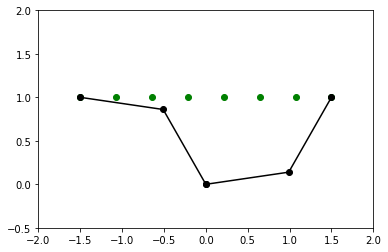

In [15]:
plt.figure()
plt.axis([-2, 2, -0.5, 2])
plt.plot(xp[:, 0], xp[:, 1], 'go')

x2, x1 = fk(q0, all_links = True)
plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')

x2, x1 = fk(qN, all_links = True)
plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')

plt.show()

# Taylor's algorithm

The algoritm plans a trajectory to move between two points in a straight line.
The line does not have to be perfect, the end effector can deviate with a distance delta.

## Some small help functions

In [101]:
def dist(p1, p2, a):
    d = norm(p1 - p2)
    if d <= 1e-6:
        raise ValueError("Line must be given by two different points")
    A = abs( (p2[1] - p1[1]) * a[0] - (p2[0] - p1[0]) * a[1] + p2[0] * p1[1] - p2[1] * p1[0] )
    return A / d

def mid_point(qv, xv, i):
    q_mid = (qv[i] + qv[i+1]) / 2
    x_mid = fk(q_mid)
    e = dist(xv[i], xv[i+1], x_mid)
    return q_mid, x_mid, e

# add point in joint and path points array
# WARNING: xsol and qsol are modified by the function
def add_point(xsol, qsol, xin, qin, ind):
    xsol.insert(ind, xin)
    qsol.insert(ind, qin)
    
def refine_grid(xsol, qsol):
    x_new = (xsol[i] + xsol[i+1]) / 2
    sol = root(lambda q : x_new - fk(q), qsol[i])
    q_new = sol['x']
    
    return x_new, q_new
    

## The algorithm

In [110]:
delta = 0.1 # acceptable deviation from path
i = 0 # current point looked at (i to i+1)
N = 2 # total number of points in solution

# initial solution
xsol = [xp[0], xp[-1]]
qsol = [q0, qN]

while(i < (N - 1)):
    
    # interpolate in joint space
    q_mid, x_mid, e = mid_point(qsol, xsol, i)
    
    # check error in task space
    if e <= delta:
        # add point to solution
        add_point(xsol, qsol, x_mid, q_mid, i+1)
        N += 1
        i += 2
    else:
        # refine grid with ik solver
        x_ref, q_ref = refine_grid(xsol, qsol)
        add_point(xsol, qsol, x_ref, q_ref, i+1)
        N +=1


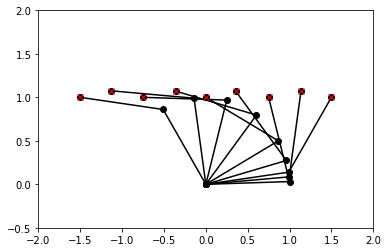

In [111]:
plt.figure()
plt.axis([-2, 2, -0.5, 2])
#plt.plot(xp[:, 0], xp[:, 1], 'go')
for j in range(len(qsol)):
    x2, x1 = fk(qsol[j], all_links = True)
    plt.plot([0, x1[0], x2[0]], [0, x1[1], x2[1]], 'ko-')
    plt.plot(xsol[j][0], xsol[j][1], 'rx')
plt.show()